In [14]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [15]:
print(torch.cuda.is_available())

True


In [16]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# Загрузка DataFrame из файла
with open(r'../datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [18]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [19]:
df['Crystal'] = Crystal
print(df['Crystal'].unique())
print(df['Stats'].unique())

['Ag' 'Al' 'Al2O3_sapphire' 'Au' 'B4C' 'Ba' 'Be' 'BeO' 'C_diamond'
 'C_graphite' 'Cr' 'Cs' 'Cu' 'Cu2MnAl' 'Fe' 'Ga' 'Gd' 'Ge' 'H2O_ice_1h'
 'He4_hcp' 'Hg' 'I2' 'K' 'Li' 'LiF' 'Mo' 'Na2Ca3Al2F14' 'Nb' 'Ni' 'Pb'
 'Pt' 'Rb' 'Si' 'Ti' 'Tl' 'UO2' 'Zn' 'Y2O3']
[1.e+07 2.e+07 5.e+07 1.e+08 2.e+08 5.e+08]


In [20]:
# Определяем целевые значения
target_crystals = ['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
                  'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
                  'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
                  'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3']

target_stats = [2.e+08, 5.e+08]

# Применяем фильтрацию к исходному датафрейму
df = df[
    df['Crystal'].isin(target_crystals) & 
    df['Stats'].isin(target_stats)
]
df = df.reset_index(drop= True)

In [21]:
# Загрузка DataFrame из файла
with open(r'../datasets/segmentation_maps.pkl', 'rb') as f:
    df_seg_maps = pickle.load(f)

In [9]:
tesr_samples = ['Al2O3_sapphire', 'C_graphite', 'Na2Ca3Al2F14', 'Rb', 'Si', 'UO2']

maxStats = 5.e+08
maxI = max(df['Pulce duration'].unique())

df_test = df[
    df['Crystal'].isin(tesr_samples) & 
    df['Stats'].isin([5.e+08]) & 
    df['Pulce duration'].isin([maxI])
]
df_test = df_test.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())

df_test_GT = df_seg_maps[
    df_seg_maps['Crystal'].isin(tesr_samples)
]
df_test_GT = df_test_GT.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
GT_test_matrices = np.array(df_test_GT['Mask'].tolist())

# Преобразование данных в тензоры PyTorch
GT_test_tensor = torch.FloatTensor(GT_test_matrices)
GT_test_tensor = GT_test_tensor.unsqueeze(1)
GT_test_tensor = GT_test_tensor.to(device)
print(GT_test_tensor.size())

torch.Size([6, 1, 250, 480])
torch.Size([6, 1, 250, 480])


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DiffractionDataset(Dataset):
    def __init__(self, df, df_seg_matrices, transform=None, crystal_list=None):
        """
        Args:
            df: DataFrame с экспериментальными данными
            df_seg_matrices: DataFrame с масками сегментации
            transform: преобразования для изображений и масок
            crystal_list: список кристаллических структур для этого датасета
        """
        self.df = df.reset_index(drop=True)
        self.df_seg_matrices = df_seg_matrices
        self.transform = transform
        
        # Если указан список кристаллов, фильтруем данные
        if crystal_list is not None:
            self.df = self.df[self.df['Crystal'].isin(crystal_list)].copy().reset_index(drop=True)
        
        # Создаем словарь для быстрого доступа к маскам
        self.mask_dict = {}
        mask_df = df_seg_matrices.set_index('Crystal')
        for crystal in mask_df.index.unique():
            mask = mask_df.loc[crystal, 'Mask']
            if isinstance(mask, pd.Series):
                mask = mask.iloc[0]  # Берем первую маску если их несколько
            self.mask_dict[crystal] = mask
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Получаем данные из df
        row = self.df.iloc[idx]
        crystal = row['Crystal']
        
        # Загружаем дифракционное изображение
        image = row['Matrix']
        
        # Получаем соответствующую маску
        mask = self.mask_dict[crystal]
        
        # Преобразуем в тензоры
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(np.array(image)).float()
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(np.array(mask)).long()
            
        # Добавляем channel dimension для изображения
        if len(image.shape) == 2:
            image = image.unsqueeze(0)  # [1, H, W]
            
        # Применяем преобразования если есть
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

# Функции для разных стратегий разделения

def split_by_crystal_stratified(df, test_size=0.2, random_state=42):
    """
    Стратегия 1: Разделяет данные так, чтобы кристаллические структуры в тесте 
    не пересекались с трейном (полное разделение по кристаллам)
    """
    # Получаем уникальные кристаллические структуры
    unique_crystals = df['Crystal'].unique()
    
    # Разделяем кристаллы на train и test
    train_crystals, test_crystals = train_test_split(
        unique_crystals, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Создаем train и test датафреймы
    train_df = df[df['Crystal'].isin(train_crystals)].copy()
    test_df = df[df['Crystal'].isin(test_crystals)].copy()
    
    print(f"Стратегия: Разделение по кристаллам (без пересечений)")
    print(f"Train crystals ({len(train_crystals)}): {train_crystals}")
    print(f"Test crystals ({len(test_crystals)}): {test_crystals}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    return train_df, test_df, train_crystals, test_crystals

def split_simple_stratified(df, test_size=0.2, random_state=42, stratify_by_crystal=True):
    """
    Стратегия 2: Простое разделение, где каждый кристалл может быть и в трейне и в тесте
    
    Args:
        stratify_by_crystal: если True, стратифицируем по кристаллам
    """
    if stratify_by_crystal:
        # Стратифицируем по кристаллам для сбалансированного разделения
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=df['Crystal'],  # Стратификация по кристаллам
            shuffle=True
        )
    else:
        # Простое случайное разделение
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
    
    # Получаем уникальные кристаллы в каждой выборке
    train_crystals = train_df['Crystal'].unique()
    test_crystals = test_df['Crystal'].unique()
    
    # Находим пересечение кристаллов
    intersection = set(train_crystals) & set(test_crystals)
    
    print(f"Стратегия: Простое разделение (с пересечениями)")
    print(f"Train crystals ({len(train_crystals)}): {len(train_crystals)} уникальных")
    print(f"Test crystals ({len(test_crystals)}): {len(test_crystals)} уникальных")
    print(f"Пересечение кристаллов: {len(intersection)} общих кристаллов")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Для совместимости возвращаем train_crystals и test_crystals
    return train_df, test_df, train_crystals, test_crystals

def split_data(df, strategy='crystal', test_size=0.2, random_state=42, **kwargs):
    """
    Основная функция разделения данных с выбором стратегии
    
    Args:
        df: DataFrame с данными
        strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        test_size: доля тестовой выборки
        random_state: seed для воспроизводимости
        **kwargs: дополнительные аргументы для стратегий
    
    Returns:
        train_df, test_df, train_crystals, test_crystals
    """
    if strategy == 'crystal':
        return split_by_crystal_stratified(df, test_size, random_state)
    elif strategy == 'simple':
        stratify_by_crystal = kwargs.get('stratify_by_crystal', True)
        return split_simple_stratified(df, test_size, random_state, stratify_by_crystal)
    else:
        raise ValueError(f"Неизвестная стратегия: {strategy}. Используйте 'crystal' или 'simple'")

In [23]:
def create_dataloaders(df, df_seg_matrices, batch_size=32, test_size=0.2, 
                       shuffle=True, num_workers=0, random_state=42,
                       split_strategy='crystal', **split_kwargs):
    """
    Создает DataLoader'ы с выбором стратегии разделения
    
    Args:
        split_strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        split_kwargs: дополнительные аргументы для стратегии разделения
    """
    print(f"\n{'='*60}")
    print(f"Создание DataLoader'ов со стратегией: {split_strategy}")
    print(f"{'='*60}")
    
    # Разделяем данные согласно выбранной стратегии
    train_df, test_df, train_crystals, test_crystals = split_data(
        df, 
        strategy=split_strategy,
        test_size=test_size, 
        random_state=random_state,
        **split_kwargs
    )
    
    # Создаем датасеты
    train_dataset = DiffractionDataset(
        train_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None  # Не фильтруем по crystal_list для простого разделения
    )
    
    test_dataset = DiffractionDataset(
        test_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None
    )
    
    # Определяем параметры для DataLoader
    loader_kwargs = {
        'batch_size': batch_size,
        'shuffle': shuffle,
        'pin_memory': True if torch.cuda.is_available() else False
    }
    
    # Добавляем num_workers только если он > 0
    if num_workers > 0:
        loader_kwargs['num_workers'] = num_workers
        loader_kwargs['persistent_workers'] = True if num_workers > 0 else False
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    
    # Для test_loader отключаем shuffle
    loader_kwargs['shuffle'] = False
    test_loader = DataLoader(test_dataset, **loader_kwargs)
    
    return train_loader, test_loader, train_crystals, test_crystals

In [24]:
# Создаем DataLoader'ы
train_loader, test_loader, train_crystals, test_crystals = create_dataloaders(
    df=df,
    df_seg_matrices=df_seg_maps,
    batch_size=3,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    split_strategy='simple' # 'crystal' 'simple'
)

# Проверяем размерность батча
for diffractions, masks in train_loader:
    print(f"Images shape: {diffractions.shape}")  # [batch_size, 1, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch_size, H, W]

    break


Создание DataLoader'ов со стратегией: simple
Стратегия: Простое разделение (с пересечениями)
Train crystals (30): 30 уникальных
Test crystals (30): 30 уникальных
Пересечение кристаллов: 30 общих кристаллов
Train samples: 960
Test samples: 240
Images shape: torch.Size([3, 1, 250, 480])
Masks shape: torch.Size([3, 250, 480])


**Чистовое**

*Что такое AlphaPolicy и как она работает?*

Идея: AlphaPolicy — это маленькая сеть, которая по входу norm_lr (твоя LR дифракция + error_matrix, т.е. 2 канала) выдаёт параметр alpha (по батчу).
Дальше alpha применяется как гейтинг к выходу SR: *sr_enhanced = sr_out * sigmoid(alpha)*

Обучение: **REINFORCE** (policy gradient):

- policy сэмплирует alpha ~ Normal(mu, std),

- ты считаешь метрики (Integral/Peak/Shape) на полученном sr_enhanced,

- превращаешь ошибки в reward (обычно reward = -loss),

- обновляешь policy по -(log_prob * reward).mean().

**Важно**: reward должен быть **[B]**, log_prob должен быть **[B]**, и метрики должны считаться **батчево**.


*Импорты и настройки*

In [3]:
import os, json, sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from SwinUNet import SwinWNet

# Добавляем путь к родительской директории
current_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(current_dir)

# ДОБАВЛЯЕМ ТАКЖЕ ПУТЬ К ПАПКЕ SUPPORT_FILES
support_files_path = os.path.join(current_dir, 'support_files')
sys.path.append(support_files_path)

# Теперь импортируем
from Diffraction_metrics import DiffractionMetricsCalculator  # Без префикса support_files

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.backends.cudnn.benchmark = True

cuda


*Модель SwinWNet + заморозка сегментаторов*

In [5]:
model = SwinWNet(
    patch_size=2,
    in_chans=1,
    error_matrix=True,
    embed_dim=48,
    depths=[2,2,2,2],
    num_heads=[3,6,12,24],
    window_size=5,
    mlp_ratio=4.,
    qkv_bias=True,
    drop=0.,
    attn_drop=0.,
    drop_path=0.
).to(device)

ckpt_path = r"../models/SwinWNet_diffraction+error_matrix.pth" 
model.load_state_dict(torch.load(ckpt_path, map_location=device))


def freeze_segmentators(model: nn.Module):
    for p in model.patch_embed.parameters(): p.requires_grad = False
    for p in model.segmentator_encoder.parameters(): p.requires_grad = False
    for p in model.segmentator_bottleneck.parameters(): p.requires_grad = False
    for p in model.segmentator_decoder.parameters(): p.requires_grad = False
    for p in model.segmentator_head.parameters(): p.requires_grad = False
    for p in model.ca_sr_to_seg.parameters(): p.requires_grad = False

freeze_segmentators(model)


C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


*Нормализация 2-канальная + ensure_2ch*

In [6]:
def ensure_2ch(x):
    # x: [B,1,H,W] -> [B,2,H,W] (diffraction + error_matrix)
    if x.size(1) == 2:
        return x
    err = torch.sqrt(torch.abs(x))
    return torch.cat([x, err], dim=1)

def normalize_piecewise_multi_channel_vectorized(x, threshold=0.01, eps=1e-6):
    x_min = x.amin(dim=(2,3), keepdim=True)
    x_max = x.amax(dim=(2,3), keepdim=True)
    x01 = (x - x_min) / (x_max - x_min + eps)
    mask = x01 > threshold
    x_strong = torch.log1p(x01) / torch.log1p(torch.tensor(1.0, device=x.device))
    x_norm = torch.where(mask, x_strong, x01)
    params = {"x_min": x_min, "x_max": x_max, "threshold": threshold}
    return x_norm, params

def denormalize_piecewise_multi_channel_vectorized(x_norm, params, eps=1e-6):
    x_min = params["x_min"]
    x_max = params["x_max"]
    threshold = params["threshold"]
    mask = x_norm > threshold
    x_strong = torch.expm1(x_norm)
    x01 = torch.where(mask, x_strong, x_norm)
    return x01 * (x_max - x_min + eps) + x_min


*AlphaPolicy + apply_action (батчево)*

In [7]:
class AlphaPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        mu = self.net(x)                 # [B,1]
        log_std = torch.zeros_like(mu)   # можно сделать обучаемым, но так ок
        std = torch.exp(log_std)         # [B,1] = 1
        return mu, std

def apply_action(sr_out, alpha):
    # sr_out: [B,2,H,W] или [B,1,H,W], alpha: [B,1]
    a = alpha.view(-1, 1, 1, 1)
    return sr_out * torch.sigmoid(a)


In [8]:
model = SwinWNet(
    patch_size=2,
    in_chans=1,
    error_matrix=True,
    embed_dim=48,
    depths=[2,2,2,2],
    num_heads=[3,6,12,24],
    window_size=5,
    mlp_ratio=4.,
    qkv_bias=True,
    drop=0.,
    attn_drop=0.,
    drop_path=0.
).to(device)

ckpt_path = r"../models/SwinWNet_finetuned_rl_simple_alpha_policy.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))

policy = AlphaPolicy().to(device)

ckpt_path = r"../models/simple_alpha_policy_trained.pth" 
policy.load_state_dict(torch.load(ckpt_path, map_location=device))

<All keys matched successfully>

*Калькулятор метрик (батчево) — Integral/Peak/Shape*

In [9]:
fixed_centers_hr = np.linspace(0.05318052, 7.49710258, 1241)
fixed_centers_lr = np.linspace(0.0546658, 7.49180085, 832)

metrics_calculator = DiffractionMetricsCalculator(
    fixed_centers_pred=fixed_centers_hr,
    fixed_centers_true=fixed_centers_hr,
    device=device
)


*RL train step БЕЗ pipe + батчи*

**Это ключевой кусок.**

Здесь:

- log_prob → [B],

- reward → [B],

- compute_all_metrics → сразу батч,

- policy обновляем **REINFORCE**,

- модель (Swin) обновляем supervised лоссом по тем же метрикам + rec (“реконструкция”).

In [10]:
def rl_train_step(
    model,
    policy,
    optimizer_policy,
    optimizer_model,
    batch_hr,                  # [B,1,H,W]
    metrics_calculator,
    device,
    lambda_rec=10.0,
    lambda_intensity=2.0,
    lambda_peak=1.0,
    lambda_shape=0.5,
):
    model.train()
    policy.train()

    hr = batch_hr.to(device)          # [B,1,H,W]
    hr2 = ensure_2ch(hr)              # [B,2,H,W]

    # --- сегментация (как у тебя) ---
    with torch.no_grad():
        seg, skips = model.segment_1(hr2)
        hr2 = hr2 * torch.sigmoid(seg)

        # LR
        lr2 = F.interpolate(hr2, scale_factor=0.5, mode="bilinear", align_corners=False)

        # нормализация
        norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr2)
        norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(hr2)

    # ---- policy ----
    mu, std = policy(norm_lr)                     # [B,1]
    dist = torch.distributions.Normal(mu, std)
    alpha = dist.rsample()                        # [B,1]
    log_prob = dist.log_prob(alpha).sum(dim=1)    # [B]

    # ---- upscale ----
    sr_out, _ = model.upscale(norm_lr, skips)     # [B,2,H,W] (раз у тебя error_matrix=True)
    sr_out = apply_action(sr_out, alpha)

    # ---- supervised reconstruction (батчево) ----
    rec_per = F.l1_loss(sr_out, norm_hr, reduction="none").mean(dim=(1,2,3))  # [B]

    # ---- метрики на denorm (батчево) ----
    with torch.no_grad():
        denorm_pred = denormalize_piecewise_multi_channel_vectorized(sr_out, params_hr)[:,0:1]
        denorm_tgt  = hr2[:,0:1]  # target в исходном масштабе после сегментации

        allm = metrics_calculator.compute_all_metrics(
            denorm_pred, denorm_tgt, d_projection=False
        )

        int_per   = torch.abs(allm["integral_pred"] - allm["integral_target"])  # [B]
        peak_per  = torch.abs(allm["peak_pred"]     - allm["peak_target"])      # [B]
        shape_per = torch.abs(allm["shape_pred"]    - allm["shape_target"])     # [B]

        total_per = (
            lambda_rec * rec_per +
            lambda_intensity * int_per +
            lambda_peak * peak_per +
            lambda_shape * shape_per
        )  # [B]

        reward = -total_per.detach()  # [B]

    # ---- policy update (REINFORCE) ----
    policy_loss = -(log_prob * reward).mean()

    optimizer_policy.zero_grad(set_to_none=True)
    policy_loss.backward()
    optimizer_policy.step()

    # ---- model fine-tune (supervised only, без градиента через метрики) ----
    sup_loss = (
        lambda_rec * rec_per +
        lambda_intensity * int_per +
        lambda_peak * peak_per +
        lambda_shape * shape_per
    ).mean()

    optimizer_model.zero_grad(set_to_none=True)
    sup_loss.backward()
    optimizer_model.step()

    return {
        "reward": reward.mean().item(),
        "rec": rec_per.mean().item(),
        "integral": int_per.mean().item(),
        "peak": peak_per.mean().item(),
        "shape": shape_per.mean().item(),
        "alpha_mean": alpha.mean().item(),
        "alpha_std": alpha.std().item(),
    }


*Train epoch (важно: **проброс optimizer_model**!)*

In [ ]:
def rl_train_step(
    model,
    policy,
    optimizer_policy,
    optimizer_model,
    images,
    masks,
    metrics_calculator,  # <-- ДОБАВЛЕНО
    device=device,
    lambda_rec=10.0,
    lambda_intensity=2.0,
    lambda_peak=1.0,
    lambda_shape=0.5):

    model.train()
    policy.train()

    images = images.to(device)          # [B,1,H,W]
    images = ensure_2ch(images)              # [B,2,H,W]

    # --- сегментация/LR/нормализация (НЕ нужно графа) ---
    with torch.no_grad():
        seg, skips = model.segment_1(images)
        seg_images = images * torch.sigmoid(seg)

        lr = F.interpolate(seg_images, scale_factor=0.5, mode="bilinear", align_corners=False)

        norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr)
        norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(seg_images)

    # =====================================================================
    # 1) POLICY UPDATE (REINFORCE): НЕ пускаем градиент в модель
    # =====================================================================
    mu, std = policy(norm_lr)                     # [B,1]
    dist = torch.distributions.Normal(mu, std)
    alpha = dist.rsample()                        # [B,1]
    log_prob = dist.log_prob(alpha).sum(dim=1)    # [B]

    with torch.no_grad():
        sr_out, _ = model.upscale(norm_lr, skips)     # <-- no grad for policy branch
        sr_out = apply_action(sr_out, alpha)

        denorm_pred_diffraction = denormalize_piecewise_multi_channel_vectorized(sr_out, params_hr)[:, 0:1]
        denorm_tgt_diffraction  = seg_images[:, 0:1]

        allm = metrics_calculator(
            batch_pred_2d=denorm_pred_diffraction,     # предсказанная 2D дифракция
            batch_true_2d=denorm_tgt_diffraction,     # ground-truth 2D
            peak_params_pred={"scale": False},
            peak_params_true={"scale": False},
            tol=0.05
        )

        int_per   = torch.FloatTensor(allm['Integral Intensity']).to(device)
        peak_per  = torch.FloatTensor(allm['Peak Intensity']).to(device)
        shape_per = torch.FloatTensor(allm['Shape']).to(device)

        # reward только из метрик (можно добавить rec, но rec надо считать тоже без града)
        total_per = (
            lambda_intensity * int_per +
            lambda_peak * peak_per +
            lambda_shape * shape_per
        )
        reward = -total_per  # [B]

    # policy_loss = -(log_prob * reward.detach()).mean()
    # Проверяем размерности
    if reward.size(0) != log_prob.size(0):
        # Создаем новый тензор нулей нужного размера
        padded_reward = torch.zeros_like(log_prob)
        
        # Копируем доступные значения reward
        min_size = min(reward.size(0), log_prob.size(0))
        padded_reward[:min_size] = reward.detach()[:min_size]
        
        # Используем дополненный reward
        policy_loss = -(log_prob * padded_reward).mean()
    else:
        policy_loss = -(log_prob * reward.detach()).mean()

    optimizer_policy.zero_grad(set_to_none=True)
    policy_loss.backward()
    optimizer_policy.step()

    # =====================================================================
    # 2) MODEL UPDATE (supervised): отдельный forward с графом
    # =====================================================================
    sr_out2, _ = model.upscale(norm_lr, skips)
    # для супервизии лучше детерминированно:
    alpha_det = mu.detach()             # [B,1], фиксируем действие, чтобы не шуметь
    sr_out2 = apply_action(sr_out2, alpha_det)

    rec_per = F.l1_loss(sr_out2, norm_hr)

    # супервизию реально оптимизирует только rec (градиент есть)
    # метрики добавляем как скалярный штраф без града (чтобы хотя бы мониторить и балансить)
    sup_loss = (lambda_rec * rec_per)

    optimizer_model.zero_grad(set_to_none=True)
    sup_loss.backward()
    optimizer_model.step()

    return {
        "reward": reward.mean().item(),
        "rec": rec_per.item(),
        "integral": int_per.mean().item(),
        "peak": peak_per.mean().item(),
        "shape": shape_per.mean().item(),
        "alpha_mean": alpha.mean().item(),
        "alpha_std": alpha.std().item(),
        "policy_loss": policy_loss.item(),
        "sup_loss": sup_loss.item(),
    }


In [12]:
from tqdm import tqdm

def train_rl_epoch(
    model,
    policy,
    train_loader,
    metrics_calculator,
    device,
    optimizer_policy,
    optimizer_model,
    lambda_rec=1.0,
    lambda_intensity=0.3,
    lambda_peak=0.3,
    lambda_shape=0.4
):
    model.eval()
    policy.train()

    stats = {
        "reward": 0.0,
        "rec": 0.0,
        "integral": 0.0,
        "peak": 0.0,
        "shape": 0.0,
        'alpha_mean': 0.0,
        'alpha_std':0.0
    }

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        mu = 100
        sigma = 0.2 * mu
        
        # Создаем шум
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        # Матрица ошибок
        error_matrix = torch.sqrt(torch.abs(images))
        images = torch.cat([images, error_matrix], dim=1)  # [B, 2, H, W]

        out = rl_train_step(
            model,
            policy,
            optimizer_policy,
            optimizer_model,
            images,
            masks,
            metrics_calculator,  # <-- ДОБАВЛЕНО
            device=device,
            lambda_rec=lambda_rec,
            lambda_intensity=lambda_intensity,
            lambda_peak=lambda_peak,
            lambda_shape=lambda_shape)

        for k in stats:
            stats[k] += out[k]

    for k in stats:
        stats[k] /= len(train_loader)

    return stats

*Запуск RL + сохранение policy*

In [25]:
policy = AlphaPolicy().to(device)

optimizer_policy = torch.optim.Adam(policy.parameters(), lr=1e-4)
optimizer_model = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-5)

cfg = dict(
    lambda_rec=10.0,
    lambda_intensity=2.0,
    lambda_peak=1.0,
    lambda_shape=0.5,
)

num_epochs = 100
for ep in range(num_epochs):
    st = train_rl_epoch(
        model=model,
        policy=policy,
        train_loader=train_loader,
        metrics_calculator=metrics_calculator,
        device=device,
        optimizer_policy=optimizer_policy,
        optimizer_model=optimizer_model,
        **cfg
    )
    print(
        f"[RL] {ep:03d} "
        f"reward={st['reward']:.4f} rec={st['rec']:.4f} "
        f"int={st['integral']:.4f} peak={st['peak']:.4f} shape={st['shape']:.6f} "
        f"alpha={st['alpha_mean']:.3f}±{st['alpha_std']:.3f}"
    )


100%|██████████| 320/320 [01:17<00:00,  4.11it/s]


[RL] 000 reward=-14.8054 rec=0.0080 int=4.9967 peak=4.7991 shape=0.025919 alpha=-0.079±0.880


 32%|███▎      | 104/320 [00:24<00:51,  4.22it/s]


KeyboardInterrupt: 

In [ ]:
# Path("models").mkdir(exist_ok=True)
torch.save(policy.state_dict(), "../models/simple_alpha_policy_trained.pth")
torch.save(model.state_dict(),  "../models/SwinWNet_finetuned_rl_simple_alpha_policy.pth")
print("Saved: policy + finetuned model")

Saved: policy + finetuned model


*Инференс с policy (детерминированно, без sample)*

In [30]:
@torch.no_grad()
def infer_with_policy(model, policy, diffractions, masks, device):
    model.eval()
    policy.eval()

    diffractions = diffractions.to(device)  

    mu = 100
    sigma = 0.2 * mu
    
    # Создаем шум
    noise = torch.randn_like(diffractions, device=device) * sigma + mu
    diffractions = diffractions + noise

    # Матрица ошибок
    error_matrix = torch.sqrt(torch.abs(diffractions))
    diffractions = torch.cat([diffractions, error_matrix], dim=1)  # [B, 2, H, W]

    seg, skips = model.segment_1(diffractions)
    diffractions = diffractions * torch.sigmoid(seg)

    lr = F.interpolate(diffractions, scale_factor=0.5, mode="bilinear", align_corners=False)

    norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr)
    norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(diffractions)

    mu, _ = policy(norm_lr)
    alpha = mu                                # deterministic

    sr, _ = model.upscale(norm_lr, skips)
    sr = apply_action(sr, alpha)

    denorm_sr = denormalize_piecewise_multi_channel_vectorized(sr, params_hr)

    # возвращаем только diffraction канал
    return denorm_sr[:,0:1], diffractions[:,0:1], alpha

@torch.no_grad()
def infer_without_policy(model, diffractions, masks, device):
    model.eval()

    diffractions = diffractions.to(device)  

    mu = 100
    sigma = 0.2 * mu
    
    # Создаем шум
    noise = torch.randn_like(diffractions, device=device) * sigma + mu
    diffractions = diffractions + noise

    # Матрица ошибок
    error_matrix = torch.sqrt(torch.abs(diffractions))
    diffractions = torch.cat([diffractions, error_matrix], dim=1)  # [B, 2, H, W]

    seg, skips = model.segment_1(diffractions)
    diffractions = diffractions * torch.sigmoid(seg)

    lr = F.interpolate(diffractions, scale_factor=0.5, mode="bilinear", align_corners=False)

    norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr)
    norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(diffractions)

    sr, _ = model.upscale(norm_lr, skips)

    denorm_sr = denormalize_piecewise_multi_channel_vectorized(sr, params_hr)

    # возвращаем только diffraction канал
    return denorm_sr[:,0:1], diffractions[:,0:1]


*Батчевые метрики для validation*

In [35]:
from tqdm import tqdm

@torch.no_grad()
def evaluate_metrics_loader(model, policy, loader, metrics_calculator, device, max_batches=20, policy_falg=True):
    model.eval()
    policy.eval()

    all_err = {"integral": [], "peak": [], "shape": []}

    for b, (diffractions, masks) in enumerate(tqdm(loader)):
        if max_batches is not None and b >= max_batches:
            break
        if policy_falg:
            denorm_pred_diffraction, denorm_tgt_diffraction, _ = infer_with_policy(model, policy, diffractions, masks, device)
        else:
            denorm_pred_diffraction, denorm_tgt_diffraction = infer_without_policy(model, diffractions, masks, device)

        # если хочешь 1-в-1 как train: лучше считать target после сегментации,
        # но для простого сравнения можно так:
        allm = metrics_calculator(
            batch_pred_2d=denorm_pred_diffraction,     # предсказанная 2D дифракция
            batch_true_2d=denorm_tgt_diffraction,     # ground-truth 2D
            peak_params_pred={"scale": False},
            peak_params_true={"scale": False},
            tol=0.05
        )

        int_per   = np.array(allm['Integral Intensity'])
        peak_per  = np.array(allm['Peak Intensity'])
        shape_per = np.array(allm['Shape'])

        all_err["integral"].append(int_per)
        all_err["peak"].append(peak_per)
        all_err["shape"].append(shape_per)

    for k in all_err:
        all_err[k] = np.concatenate(all_err[k], axis=0) if len(all_err[k]) else np.array([])
    return all_err

In [32]:
import seaborn as sns

def summarize_errors(errs: np.ndarray):
    if errs.size == 0:
        return {"mean": np.nan, "median": np.nan, "p95": np.nan}
    return {
        "mean": float(np.mean(errs)),
        "median": float(np.median(errs)),
        "p95": float(np.percentile(errs, 95)),
    }

def plot_compare_error_distributions(results, bins=None, xlims=None, title="Policy vs No-Policy"):
    """
    results = evaluate_metrics_loader(...) output
    """
    sns.set_theme(style="white")  # без сетки

    metrics = ["integral", "peak", "shape"]
    if bins is None:
        bins = {"integral": 200, "peak": 200, "shape": 150}
    if xlims is None:
        xlims = {"integral": None, "peak": None, "shape": None}

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title, fontsize=16)

    palette = {
        "no_policy": "#1f77b4",  # синий
        "policy":    "#d62728",  # красный
    }

    for ax, m in zip(axes, metrics):
        a = np.asarray(results["no_policy"][m]); a = a[np.isfinite(a)]
        b = np.asarray(results["policy"][m]);    b = b[np.isfinite(b)]

        # overlay hist
        sns.histplot(a, bins=bins[m], stat="density", kde=True, color=palette["no_policy"], alpha=0.35, ax=ax, label="no_policy")
        sns.histplot(b, bins=bins[m], stat="density", kde=True, color=palette["policy"],    alpha=0.35, ax=ax, label="policy(mu)")

        ax.set_title(m)
        ax.set_xlabel("abs error")
        ax.set_ylabel("density")
        ax.tick_params(axis="both", which="both", direction="in")
        ax.grid(False)
        if xlims.get(m) is not None:
            ax.set_xlim(*xlims[m])

        sa = summarize_errors(a)
        sb = summarize_errors(b)
        ax.text(
            0.02, 0.98,
            f"NO   mean={sa['mean']:.3g} med={sa['median']:.3g} p95={sa['p95']:.3g}\n"
            f"POL  mean={sb['mean']:.3g} med={sb['median']:.3g} p95={sb['p95']:.3g}",
            transform=ax.transAxes,
            ha="left", va="top"
        )
        ax.legend()

    plt.tight_layout()
    plt.show()

100%|██████████| 320/320 [00:32<00:00,  9.74it/s]


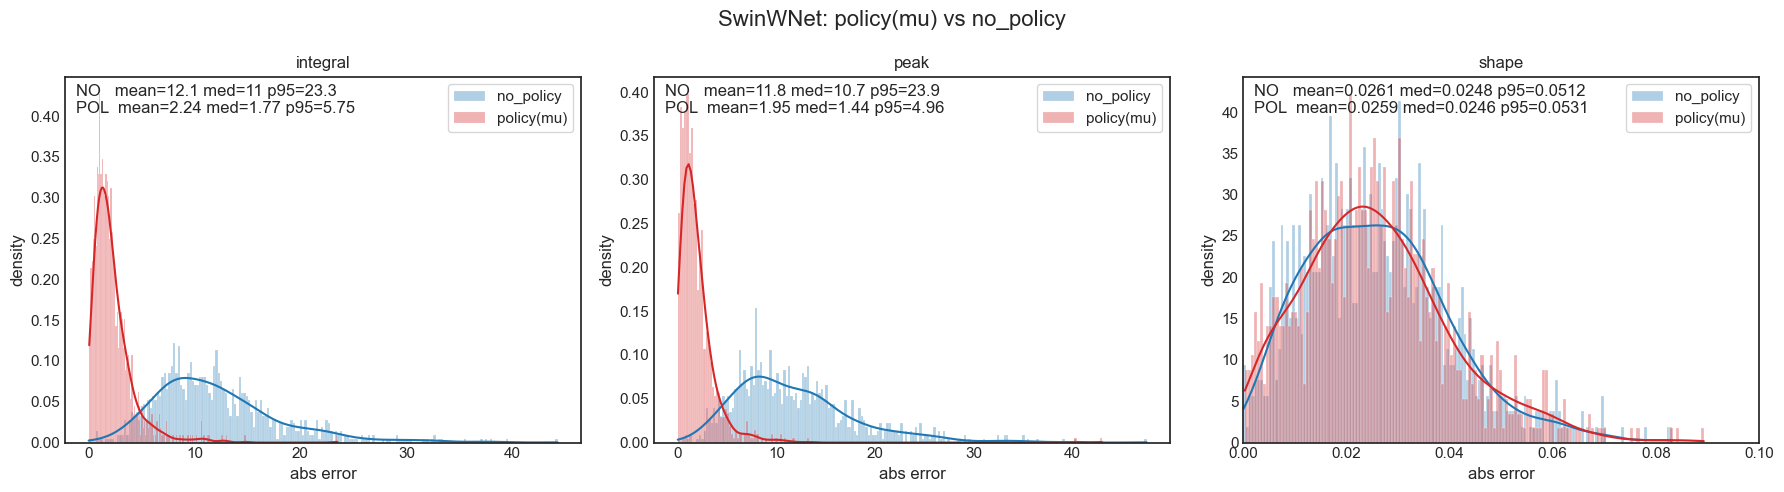

In [37]:
import matplotlib.pyplot as plt

res = {'no_policy': {}, "policy": {}}

res['no_policy'] = evaluate_metrics_loader(model=model,
                                        policy=policy,
                                        loader=train_loader,
                                        metrics_calculator=metrics_calculator,
                                        device=device, 
                                        max_batches=None, 
                                        policy_falg=False)

res['policy'] = evaluate_metrics_loader(model=model,
                                        policy=policy,
                                        loader=train_loader,
                                        metrics_calculator=metrics_calculator,
                                        device=device, 
                                        max_batches=None, 
                                        policy_falg=True)

plot_compare_error_distributions(
    res,
    bins={"integral": 200, "peak": 200, "shape": 150},
    xlims={"integral": None, "peak": None, "shape": (0, 0.1)},
    title="SwinWNet: policy(mu) vs no_policy"
)

In [38]:
len(res['policy']["integral"].tolist())

959

In [ ]:
import json

with open("../results/SwinWnet_simple_alpha_policy_diffraction+error_matrix_physycal_metrics.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": res['policy']["integral"].tolist(),
            "Peak Intensity losses": res['policy']["peak"].tolist(),
            "Shape_losses": res['policy']["shape"].tolist()
        },
        f,
        indent=4,
        ensure_ascii=False
    )

**Другая стратегия**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

def ensure_2ch(x: torch.Tensor) -> torch.Tensor:
    """
    x: [B,1,H,W] -> [B,2,H,W] (diffraction + sqrt(abs(diffraction)))
    если уже 2 канала — вернёт как есть
    """
    if x.dim() != 4:
        raise ValueError(f"Expected [B,C,H,W], got {x.shape}")
    if x.size(1) == 2:
        return x
    if x.size(1) != 1:
        raise ValueError(f"Expected C=1 or C=2, got C={x.size(1)}")
    err = torch.sqrt(torch.abs(x) + 1e-12)
    return torch.cat([x, err], dim=1)

class RunningNorm:
    """
    Нормализация метрик по батчам: z-score (running mean/var).
    Нужна, чтобы integral/peak/shape были сопоставимы в reward.
    """
    def __init__(self, momentum=0.01, eps=1e-8, device="cpu"):
        self.m = momentum
        self.eps = eps
        self.device = device
        self.mean = {}
        self.var = {}

    @torch.no_grad()
    def update(self, name: str, x: torch.Tensor):
        # x: [B]
        x = x.detach()
        mu = x.mean()
        vr = x.var(unbiased=False)

        if name not in self.mean:
            self.mean[name] = mu
            self.var[name] = vr + self.eps
        else:
            self.mean[name] = (1 - self.m) * self.mean[name] + self.m * mu
            self.var[name]  = (1 - self.m) * self.var[name]  + self.m * (vr + self.eps)

    @torch.no_grad()
    def zscore(self, name: str, x: torch.Tensor) -> torch.Tensor:
        # x: [B]
        if name not in self.mean:
            self.update(name, x)
        return (x - self.mean[name]) / torch.sqrt(self.var[name] + self.eps)

def sobel_edges(x):
    """
    x: [B,1,H,W] -> градиентная "энергия" [B,1,H,W]
    """
    kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-12)

def fft_amp(x):
    """
    x: [B,1,H,W] -> амплитуда FFT [B,1,H,W]
    """
    X = torch.fft.rfft2(x, norm="ortho")
    return torch.abs(X)

def fft_loss(pred, tgt):
    return F.l1_loss(fft_amp(pred), fft_amp(tgt))

def grad_loss(pred, tgt):
    return F.l1_loss(sobel_edges(pred), sobel_edges(tgt))


**AlphaPolicy (learnable std, маленький, стабильный)**

In [18]:
class AlphaPolicy(nn.Module):
    def __init__(self, in_ch=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(16, 1),
        )
        # стартуем с маленького std
        self.log_std = nn.Parameter(torch.tensor([-2.0]))  # std ~ 0.135

    def forward(self, x):
        mu = self.net(x)                    # [B,1]
        std = self.log_std.exp().expand_as(mu).clamp(0.01, 0.3)
        return mu, std


*RL train step (policy update + model update) — БЕЗ двойного backward*

In [26]:
policy = AlphaPolicy(in_ch=2).to(device)

optimizer_policy = torch.optim.Adam(policy.parameters(), lr=1e-4)
optimizer_model  = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5
)

running_norm = RunningNorm(momentum=0.01, device=device)


TypeError: AlphaPolicy.__init__() got an unexpected keyword argument 'in_ch'

Reward-функция (аккуратно и отдельно)

In [20]:
@torch.no_grad()
def compute_reward(
    sr_out,
    gt,
    metrics_calculator,
    running_norm,
    device,
    w_int=1.0,
    w_peak=1.0,
    w_shape=1.0,
    w_grad=0.2,
    w_fft=0.2,
):
    """
    sr_out, gt: [B,1,H,W] (DENORMALIZED!)
    """

    allm = metrics_calculator(
        batch_pred_2d=sr_out,
        batch_true_2d=gt,
        peak_params_pred={"scale": False},
        peak_params_true={"scale": False},
        tol=0.05
    )

    int_per   = torch.tensor(allm["Integral Intensity"], device=device)
    peak_per  = torch.tensor(allm["Peak Intensity"], device=device)
    shape_per = torch.tensor(allm["Shape"], device=device)

    # обновляем running z-score
    running_norm.update("int", int_per)
    running_norm.update("peak", peak_per)
    running_norm.update("shape", shape_per)

    z_int   = running_norm.zscore("int", int_per)
    z_peak  = running_norm.zscore("peak", peak_per)
    z_shape = running_norm.zscore("shape", shape_per)

    grad_l = grad_loss(sr_out, gt)
    fft_l  = fft_loss(sr_out, gt)

    reward = -(
        w_int   * z_int +
        w_peak  * z_peak +
        w_shape * z_shape +
        w_grad  * grad_l +
        w_fft   * fft_l
    )

    return reward, {
        "int": int_per.mean().item(),
        "peak": peak_per.mean().item(),
        "shape": shape_per.mean().item(),
        "grad": grad_l.item(),
        "fft": fft_l.item(),
    }


Один RL + SR шаг

In [21]:
def rl_train_step_v2(
    model,
    policy,
    optimizer_policy,
    optimizer_model,
    images,
    masks,
    metrics_calculator,
    running_norm,
    device,
    lambda_rec=10.0,
):

    model.train()
    policy.train()

    images = images.to(device)
    images = ensure_2ch(images)  # [B,2,H,W]

    # ===============================
    # Preprocess (NO grad)
    # ===============================
    with torch.no_grad():
        seg, skips = model.segment_1(images)
        seg_images = images * torch.sigmoid(seg)

        lr = F.interpolate(seg_images, scale_factor=0.5, mode="bilinear", align_corners=False)

        norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr)
        norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(seg_images)

    # ============================================================
    # 1) POLICY UPDATE (REINFORCE)
    # ============================================================
    mu, std = policy(norm_lr)
    dist = torch.distributions.Normal(mu, std)

    alpha = dist.rsample()                       # [B,1]
    log_prob = dist.log_prob(alpha).sum(dim=1)  # [B]

    with torch.no_grad():
        sr_rl, _ = model.upscale(norm_lr, skips)
        sr_rl = apply_action(sr_rl, alpha)

        pred = denormalize_piecewise_multi_channel_vectorized(sr_rl, params_hr)[:, :1]
        tgt  = seg_images[:, :1]

        reward, r_stats = compute_reward(
            pred, tgt,
            metrics_calculator,
            running_norm,
            device
        )

    # baseline → advantage
    advantage = reward - reward.mean()

    policy_loss = -(log_prob * advantage).mean()

    optimizer_policy.zero_grad(set_to_none=True)
    policy_loss.backward()
    optimizer_policy.step()

    # ============================================================
    # 2) MODEL UPDATE (SUPERVISED)
    # ============================================================
    sr_sup, _ = model.upscale(norm_lr, skips)

    alpha_det = mu.detach()
    sr_sup = apply_action(sr_sup, alpha_det)

    rec_loss = F.l1_loss(sr_sup, norm_hr)

    optimizer_model.zero_grad(set_to_none=True)
    (lambda_rec * rec_loss).backward()
    optimizer_model.step()

    return {
        "reward": reward.mean().item(),
        "policy_loss": policy_loss.item(),
        "rec": rec_loss.item(),
        "alpha_mean": alpha.mean().item(),
        "alpha_std": alpha.std().item(),
        **r_stats,
    }


Epoch loop

In [22]:
def train_rl_epoch_v2(
    model,
    policy,
    train_loader,
    metrics_calculator,
    running_norm,
    optimizer_policy,
    optimizer_model,
    device,
):

    stats = {}

    for images, masks in train_loader:
        images = images.to(device)

        out = rl_train_step_v2(
            model=model,
            policy=policy,
            optimizer_policy=optimizer_policy,
            optimizer_model=optimizer_model,
            images=images,
            masks=masks,
            metrics_calculator=metrics_calculator,
            running_norm=running_norm,
            device=device,
        )

        for k, v in out.items():
            stats[k] = stats.get(k, 0.0) + v

    for k in stats:
        stats[k] /= len(train_loader)

    return stats


In [24]:
num_epochs = 100
for ep in range(num_epochs):
    st = train_rl_epoch_v2(
            model,
            policy,
            train_loader,
            metrics_calculator,
            running_norm,
            optimizer_policy,
            optimizer_model,
            device,
        )
    print(
        f"[RL] {ep:03d} "
        f"reward={st['reward']:.4f} rec={st['rec']:.4f} "
        f"int={st['integral']:.4f} peak={st['peak']:.4f} shape={st['shape']:.6f} "
        f"alpha={st['alpha_mean']:.3f}±{st['alpha_std']:.3f}"
    )

NameError: name 'apply_action' is not defined

In [23]:
@torch.no_grad()
def compute_metric_errors(metrics_calculator, pred_2d, tgt_2d, d_projection=False):
    """
    pred_2d, tgt_2d: [B,1,H,W] (денормированные)
    returns: (int_err, peak_err, shape_err) each [B]
    """
    allm = metrics_calculator.compute_all_metrics(pred_2d, tgt_2d, d_projection=d_projection)
    int_err   = torch.abs(allm["integral_pred"] - allm["integral_target"])
    peak_err  = torch.abs(allm["peak_pred"]     - allm["peak_target"])
    shape_err = torch.abs(allm["shape_pred"]    - allm["shape_target"])
    return int_err, peak_err, shape_err


def rl_train_step(
    model,
    policy,
    optimizer_policy,
    optimizer_model,
    batch_hr,                 # [B,1,H,W] from loader + noise already applied
    metrics_calculator,
    rn: RunningNorm,
    device,
    # reward weights
    w_int=1.0,
    w_peak=1.0,
    w_shape=1.0,
    # supervised weights
    lambda_rec=10.0,
    lambda_fft=0.5,
    lambda_grad=0.5,
    d_projection=False,
):
    model.train()
    policy.train()

    hr = batch_hr.to(device)          # [B,1,H,W]
    hr2 = ensure_2ch(hr)              # [B,2,H,W]

    # ---- segmentation/LR/norm (без графа) ----
    with torch.no_grad():
        seg, skips = model.segment_1(hr2)
        hr2 = hr2 * torch.sigmoid(seg)

        lr2 = F.interpolate(hr2, scale_factor=0.5, mode="bilinear", align_corners=False)

        norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr2)
        norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(hr2)

    # =========================================================
    # 1) POLICY UPDATE (REINFORCE + advantage baseline)
    # =========================================================
    mu, std = policy(norm_lr)                         # [B,1]
    dist = torch.distributions.Normal(mu, std)
    alpha = dist.rsample()                            # [B,1]
    log_prob = dist.log_prob(alpha).sum(dim=1)        # [B]

    with torch.no_grad():
        sr, _ = model.upscale(norm_lr, skips)
        sr = apply_action(sr, alpha)

        den_pred = denormalize_piecewise_multi_channel_vectorized(sr, params_hr)[:, 0:1]
        den_tgt  = hr2[:, 0:1]

        int_err, peak_err, shape_err = compute_metric_errors(
            metrics_calculator, den_pred, den_tgt, d_projection=d_projection
        )

        # update running stats + z-score normalize
        rn.update("integral", int_err)
        rn.update("peak", peak_err)
        rn.update("shape", shape_err)

        int_z   = rn.zscore("integral", int_err)
        peak_z  = rn.zscore("peak", peak_err)
        shape_z = rn.zscore("shape", shape_err)

        # reward: хотим минимизировать -> reward = -(...) ; [B]
        reward = -(w_int * int_z + w_peak * peak_z + w_shape * shape_z)

        # advantage baseline
        adv = reward - reward.mean()

    policy_loss = -(log_prob * adv.detach()).mean()

    optimizer_policy.zero_grad(set_to_none=True)
    policy_loss.backward()
    optimizer_policy.step()

    # =========================================================
    # 2) MODEL UPDATE (дифференцируемый суррогат)
    #    используем alpha детерминированно (=mu) и detach, чтобы не шуметь
    # =========================================================
    alpha_det = mu.detach()                           # [B,1]
    sr2, _ = model.upscale(norm_lr, skips)
    sr2 = apply_action(sr2, alpha_det)

    # supervised losses считаем по diffraction-каналу (0:1)
    pred_norm = sr2[:, 0:1]
    tgt_norm  = norm_hr[:, 0:1]

    rec = F.l1_loss(pred_norm, tgt_norm)
    ffl = fft_loss(pred_norm, tgt_norm)
    grl = grad_loss(pred_norm, tgt_norm)

    sup_loss = lambda_rec * rec + lambda_fft * ffl + lambda_grad * grl

    optimizer_model.zero_grad(set_to_none=True)
    sup_loss.backward()
    optimizer_model.step()

    # ---- лог для печати ----
    with torch.no_grad():
        return {
            "reward": reward.mean().item(),
            "policy_loss": policy_loss.item(),
            "sup_loss": sup_loss.item(),
            "rec": rec.item(),
            "fft": ffl.item(),
            "grad": grl.item(),
            "integral": int_err.mean().item(),
            "peak": peak_err.mean().item(),
            "shape": shape_err.mean().item(),
            "alpha_mean": alpha_det.mean().item(),
            "alpha_std": std.mean().item(),
        }


*Train epoch + запуск*

In [34]:
from tqdm import tqdm

def train_rl_epoch(
    model,
    policy,
    train_loader,
    metrics_calculator,
    device,
    optimizer_policy,
    optimizer_model,
    rn: RunningNorm,
    noise_mu=100.0,
    noise_sigma_frac=0.2,
    **step_kwargs
):
    stats = {
        "reward": 0.0,
        "policy_loss": 0.0,
        "sup_loss": 0.0,
        "rec": 0.0,
        "fft": 0.0,
        "grad": 0.0,
        "integral": 0.0,
        "peak": 0.0,
        "shape": 0.0,
        "alpha_mean": 0.0,
        "alpha_std": 0.0,
    }

    model.train()
    policy.train()

    for hr, _ in tqdm(train_loader, desc="RL epoch"):
        hr = hr.to(device)  # [B,1,H,W]

        sigma = noise_sigma_frac * noise_mu
        noise = torch.randn_like(hr) * sigma + noise_mu
        hr_noisy = hr + noise

        out = rl_train_step(
            model=model,
            policy=policy,
            optimizer_policy=optimizer_policy,
            optimizer_model=optimizer_model,
            batch_hr=hr_noisy,
            metrics_calculator=metrics_calculator,
            rn=rn,
            device=device,
            **step_kwargs
        )

        for k in stats:
            stats[k] += out[k]

    n = len(train_loader)
    for k in stats:
        stats[k] /= max(n, 1)
    return stats


**Запуск**

In [35]:
policy = AlphaPolicy().to(device)
optimizer_policy = torch.optim.Adam(policy.parameters(), lr=3e-4)  # чуть больше
optimizer_model  = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-5)

rn = RunningNorm(momentum=0.01, device=device)

cfg = dict(
    # reward weights (после z-score они сопоставимы)
    w_int=1.0, w_peak=1.0, w_shape=1.0,
    # supervised weights
    lambda_rec=10.0,
    lambda_fft=0.5,
    lambda_grad=0.5,
    d_projection=False,
)

num_epochs = 100
for ep in range(num_epochs):
    st = train_rl_epoch(
        model=model,
        policy=policy,
        train_loader=train_loader,
        metrics_calculator=metrics_calculator,
        device=device,
        optimizer_policy=optimizer_policy,
        optimizer_model=optimizer_model,
        rn=rn,
        noise_mu=100.0,
        noise_sigma_frac=0.2,
        **cfg
    )

    print(
        f"[RL] {ep:03d} "
        f"reward={st['reward']:.4f} "
        f"int={st['integral']:.1f} peak={st['peak']:.2f} shape={st['shape']:.6f} | "
        f"rec={st['rec']:.5f} fft={st['fft']:.5f} grad={st['grad']:.5f} | "
        f"alpha={st['alpha_mean']:.3f} std={st['alpha_std']:.3f}"
    )


RL epoch: 100%|██████████| 320/320 [00:40<00:00,  7.89it/s]


[RL] 000 reward=-0.3897 int=1007161.1 peak=577.14 shape=0.000418 | rec=0.00668 fft=0.01327 grad=0.02754 | alpha=-0.169 std=0.134


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.06it/s]


[RL] 001 reward=-0.0065 int=1013131.6 peak=545.16 shape=0.000426 | rec=0.00664 fft=0.01313 grad=0.02704 | alpha=-0.169 std=0.135


RL epoch: 100%|██████████| 320/320 [00:40<00:00,  7.99it/s]


[RL] 002 reward=0.0556 int=1008826.8 peak=530.35 shape=0.000405 | rec=0.00661 fft=0.01306 grad=0.02684 | alpha=-0.169 std=0.134


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.04it/s]


[RL] 003 reward=0.0148 int=1003927.0 peak=524.40 shape=0.000401 | rec=0.00660 fft=0.01303 grad=0.02679 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 004 reward=0.0388 int=1030534.1 peak=509.55 shape=0.000399 | rec=0.00661 fft=0.01302 grad=0.02669 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 005 reward=0.0068 int=1043444.3 peak=491.59 shape=0.000450 | rec=0.00664 fft=0.01296 grad=0.02661 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 006 reward=0.0815 int=1000065.1 peak=500.05 shape=0.000390 | rec=0.00659 fft=0.01294 grad=0.02650 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 007 reward=-0.0632 int=1026790.0 peak=490.87 shape=0.000388 | rec=0.00657 fft=0.01292 grad=0.02646 | alpha=-0.169 std=0.134


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 008 reward=-0.0052 int=1038882.9 peak=482.62 shape=0.000388 | rec=0.00658 fft=0.01291 grad=0.02643 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 009 reward=0.0433 int=1036846.3 peak=477.54 shape=0.000386 | rec=0.00655 fft=0.01286 grad=0.02632 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.06it/s]


[RL] 010 reward=0.0110 int=1032660.5 peak=473.98 shape=0.000385 | rec=0.00666 fft=0.01288 grad=0.02640 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 011 reward=0.0098 int=1036191.6 peak=466.34 shape=0.000381 | rec=0.00656 fft=0.01284 grad=0.02625 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 012 reward=0.0155 int=1024055.2 peak=475.70 shape=0.000383 | rec=0.00654 fft=0.01277 grad=0.02609 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 013 reward=-0.0121 int=1020908.9 peak=481.62 shape=0.000381 | rec=0.00655 fft=0.01282 grad=0.02623 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:40<00:00,  7.98it/s]


[RL] 014 reward=0.0587 int=1015580.4 peak=461.42 shape=0.000378 | rec=0.00653 fft=0.01275 grad=0.02607 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.04it/s]


[RL] 015 reward=-0.0338 int=1053810.6 peak=453.28 shape=0.000379 | rec=0.00656 fft=0.01276 grad=0.02616 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.03it/s]


[RL] 016 reward=-0.0257 int=1034149.2 peak=459.59 shape=0.000378 | rec=0.00655 fft=0.01277 grad=0.02616 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 017 reward=0.0381 int=1025725.4 peak=456.67 shape=0.000374 | rec=0.00655 fft=0.01278 grad=0.02615 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 018 reward=-0.0171 int=1021799.9 peak=456.33 shape=0.000375 | rec=0.00657 fft=0.01274 grad=0.02605 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 019 reward=0.0677 int=1029446.8 peak=451.86 shape=0.000372 | rec=0.00653 fft=0.01276 grad=0.02608 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 020 reward=-0.0019 int=1032604.4 peak=457.06 shape=0.000374 | rec=0.00652 fft=0.01272 grad=0.02598 | alpha=-0.169 std=0.133


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 021 reward=-0.0023 int=1056943.2 peak=450.73 shape=0.000373 | rec=0.00653 fft=0.01270 grad=0.02597 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 022 reward=-0.0085 int=1028099.1 peak=451.41 shape=0.000372 | rec=0.00647 fft=0.01267 grad=0.02583 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 023 reward=0.0483 int=1031942.4 peak=446.79 shape=0.000372 | rec=0.00652 fft=0.01271 grad=0.02598 | alpha=-0.169 std=0.132


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 024 reward=-0.0154 int=1017340.4 peak=449.67 shape=0.000371 | rec=0.00655 fft=0.01267 grad=0.02589 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 025 reward=0.0259 int=1023607.8 peak=442.05 shape=0.000370 | rec=0.00659 fft=0.01268 grad=0.02597 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.05it/s]


[RL] 026 reward=0.0372 int=1027633.6 peak=436.82 shape=0.000366 | rec=0.00653 fft=0.01265 grad=0.02582 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.08it/s]


[RL] 027 reward=0.0109 int=1036582.9 peak=439.39 shape=0.000369 | rec=0.00647 fft=0.01262 grad=0.02577 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 028 reward=-0.0384 int=1034578.9 peak=442.56 shape=0.000369 | rec=0.00656 fft=0.01267 grad=0.02601 | alpha=-0.169 std=0.131


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 029 reward=-0.0085 int=1037495.1 peak=437.40 shape=0.000367 | rec=0.00652 fft=0.01264 grad=0.02590 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 030 reward=0.0505 int=1031522.1 peak=441.07 shape=0.000367 | rec=0.00648 fft=0.01258 grad=0.02570 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 031 reward=-0.0111 int=1021272.6 peak=437.42 shape=0.000365 | rec=0.00646 fft=0.01259 grad=0.02566 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 032 reward=0.0181 int=1050305.9 peak=436.53 shape=0.000367 | rec=0.00647 fft=0.01259 grad=0.02569 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 033 reward=-0.0126 int=1026995.1 peak=440.07 shape=0.000365 | rec=0.00646 fft=0.01257 grad=0.02567 | alpha=-0.169 std=0.129


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 034 reward=0.0485 int=1014011.9 peak=441.63 shape=0.000366 | rec=0.00646 fft=0.01256 grad=0.02564 | alpha=-0.169 std=0.129


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 035 reward=-0.0207 int=1026135.1 peak=435.63 shape=0.000365 | rec=0.00645 fft=0.01254 grad=0.02557 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 036 reward=0.0335 int=1041429.5 peak=427.98 shape=0.000363 | rec=0.00645 fft=0.01253 grad=0.02557 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 037 reward=0.0150 int=1027898.1 peak=436.08 shape=0.000364 | rec=0.00646 fft=0.01254 grad=0.02563 | alpha=-0.169 std=0.130


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 038 reward=0.0100 int=1028945.7 peak=432.28 shape=0.000363 | rec=0.00647 fft=0.01255 grad=0.02567 | alpha=-0.169 std=0.129


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


[RL] 039 reward=-0.0237 int=1035552.9 peak=432.10 shape=0.000363 | rec=0.00646 fft=0.01252 grad=0.02559 | alpha=-0.169 std=0.129


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.10it/s]


[RL] 040 reward=0.0247 int=1030085.5 peak=428.31 shape=0.000362 | rec=0.00646 fft=0.01252 grad=0.02558 | alpha=-0.169 std=0.128


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 041 reward=0.0220 int=1035113.1 peak=424.96 shape=0.000361 | rec=0.00643 fft=0.01251 grad=0.02553 | alpha=-0.169 std=0.128


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 042 reward=0.0132 int=1030783.8 peak=419.99 shape=0.000360 | rec=0.00642 fft=0.01246 grad=0.02539 | alpha=-0.169 std=0.127


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 043 reward=-0.0265 int=1034671.8 peak=419.25 shape=0.000361 | rec=0.00648 fft=0.01253 grad=0.02564 | alpha=-0.169 std=0.127


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 044 reward=0.0118 int=1033057.6 peak=430.90 shape=0.000361 | rec=0.00646 fft=0.01250 grad=0.02553 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


[RL] 045 reward=0.0063 int=1041977.7 peak=423.74 shape=0.000361 | rec=0.00648 fft=0.01247 grad=0.02541 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 046 reward=0.0251 int=1030902.4 peak=410.16 shape=0.000359 | rec=0.00641 fft=0.01244 grad=0.02538 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 047 reward=-0.0039 int=1040884.3 peak=430.46 shape=0.000360 | rec=0.00639 fft=0.01240 grad=0.02525 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 048 reward=0.0429 int=1036747.9 peak=413.94 shape=0.000356 | rec=0.00641 fft=0.01246 grad=0.02538 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 049 reward=0.0190 int=1010986.9 peak=429.84 shape=0.000359 | rec=0.00640 fft=0.01245 grad=0.02536 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 050 reward=-0.0517 int=1030895.6 peak=422.79 shape=0.000357 | rec=0.00643 fft=0.01247 grad=0.02545 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 051 reward=0.0589 int=1025762.7 peak=419.29 shape=0.000358 | rec=0.00639 fft=0.01240 grad=0.02525 | alpha=-0.169 std=0.124


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 052 reward=-0.0270 int=1028444.8 peak=413.03 shape=0.000357 | rec=0.00640 fft=0.01244 grad=0.02533 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 053 reward=0.0267 int=1038973.9 peak=411.83 shape=0.000357 | rec=0.00644 fft=0.01245 grad=0.02542 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 054 reward=-0.0152 int=1037389.5 peak=414.11 shape=0.000358 | rec=0.00640 fft=0.01238 grad=0.02525 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 055 reward=0.0675 int=1027206.3 peak=414.51 shape=0.000356 | rec=0.00641 fft=0.01241 grad=0.02531 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 056 reward=-0.0065 int=1024302.5 peak=414.56 shape=0.000356 | rec=0.00639 fft=0.01236 grad=0.02520 | alpha=-0.169 std=0.126


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.20it/s]


[RL] 057 reward=-0.0261 int=1029958.9 peak=412.65 shape=0.000356 | rec=0.00639 fft=0.01238 grad=0.02528 | alpha=-0.169 std=0.125


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 058 reward=0.0521 int=1033909.0 peak=413.95 shape=0.000356 | rec=0.00638 fft=0.01238 grad=0.02520 | alpha=-0.169 std=0.124


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 059 reward=-0.0013 int=1036562.9 peak=416.21 shape=0.000356 | rec=0.00643 fft=0.01239 grad=0.02529 | alpha=-0.169 std=0.124


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 060 reward=0.0021 int=1022930.3 peak=412.74 shape=0.000355 | rec=0.00640 fft=0.01238 grad=0.02526 | alpha=-0.169 std=0.124


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 061 reward=0.0156 int=1022653.3 peak=414.20 shape=0.000354 | rec=0.00647 fft=0.01246 grad=0.02556 | alpha=-0.169 std=0.123


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 062 reward=-0.0046 int=1015684.7 peak=415.16 shape=0.000355 | rec=0.00639 fft=0.01239 grad=0.02524 | alpha=-0.169 std=0.123


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 063 reward=-0.0141 int=1040779.1 peak=410.55 shape=0.000357 | rec=0.00641 fft=0.01236 grad=0.02519 | alpha=-0.169 std=0.123


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 064 reward=0.0300 int=1034824.5 peak=405.37 shape=0.000353 | rec=0.00638 fft=0.01237 grad=0.02522 | alpha=-0.169 std=0.124


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 065 reward=0.0260 int=1028818.1 peak=406.46 shape=0.000354 | rec=0.00641 fft=0.01237 grad=0.02524 | alpha=-0.169 std=0.123


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 066 reward=-0.0068 int=1039335.8 peak=404.59 shape=0.000354 | rec=0.00641 fft=0.01238 grad=0.02525 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 067 reward=0.0111 int=1035097.7 peak=410.63 shape=0.000353 | rec=0.00633 fft=0.01229 grad=0.02496 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 068 reward=0.0038 int=1011568.1 peak=412.82 shape=0.000352 | rec=0.00642 fft=0.01236 grad=0.02523 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 069 reward=-0.0293 int=1042217.1 peak=414.83 shape=0.000355 | rec=0.00637 fft=0.01231 grad=0.02512 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 070 reward=0.0745 int=1011758.4 peak=408.37 shape=0.000350 | rec=0.00637 fft=0.01232 grad=0.02510 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 071 reward=-0.0146 int=1050153.2 peak=404.26 shape=0.000352 | rec=0.00635 fft=0.01230 grad=0.02499 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 072 reward=0.0556 int=1028319.8 peak=407.30 shape=0.000352 | rec=0.00634 fft=0.01228 grad=0.02492 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 073 reward=0.0365 int=1019255.2 peak=411.14 shape=0.000351 | rec=0.00643 fft=0.01238 grad=0.02528 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 074 reward=-0.0236 int=1034285.0 peak=398.14 shape=0.000352 | rec=0.00638 fft=0.01231 grad=0.02506 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 075 reward=0.0301 int=1020716.9 peak=401.30 shape=0.000351 | rec=0.00637 fft=0.01232 grad=0.02510 | alpha=-0.169 std=0.123


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 076 reward=-0.0572 int=1036270.1 peak=403.93 shape=0.000351 | rec=0.00632 fft=0.01227 grad=0.02492 | alpha=-0.169 std=0.122


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 077 reward=0.0230 int=1036687.9 peak=400.91 shape=0.000353 | rec=0.00633 fft=0.01226 grad=0.02496 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 078 reward=0.0320 int=1029416.9 peak=397.37 shape=0.000348 | rec=0.00636 fft=0.01227 grad=0.02496 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]


[RL] 079 reward=-0.0478 int=1013230.9 peak=402.86 shape=0.000350 | rec=0.00636 fft=0.01229 grad=0.02503 | alpha=-0.169 std=0.120


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.18it/s]


[RL] 080 reward=0.0600 int=1048966.9 peak=395.21 shape=0.000348 | rec=0.00631 fft=0.01223 grad=0.02487 | alpha=-0.169 std=0.120


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 081 reward=-0.0250 int=1039867.1 peak=395.36 shape=0.000350 | rec=0.00633 fft=0.01227 grad=0.02494 | alpha=-0.169 std=0.120


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 082 reward=-0.0357 int=1037805.6 peak=398.66 shape=0.000350 | rec=0.00636 fft=0.01225 grad=0.02497 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 083 reward=0.0612 int=1012876.9 peak=402.33 shape=0.000351 | rec=0.00635 fft=0.01223 grad=0.02488 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 084 reward=-0.0059 int=1037926.9 peak=392.93 shape=0.000348 | rec=0.00634 fft=0.01228 grad=0.02499 | alpha=-0.169 std=0.121


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 085 reward=-0.0026 int=1050263.6 peak=392.11 shape=0.000349 | rec=0.00633 fft=0.01225 grad=0.02489 | alpha=-0.169 std=0.120


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 086 reward=0.0596 int=1024080.4 peak=401.15 shape=0.000348 | rec=0.00634 fft=0.01226 grad=0.02491 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 087 reward=-0.0259 int=1047419.6 peak=397.90 shape=0.000348 | rec=0.00637 fft=0.01227 grad=0.02505 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.19it/s]


[RL] 088 reward=0.0124 int=1027335.1 peak=398.00 shape=0.000349 | rec=0.00634 fft=0.01221 grad=0.02480 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 089 reward=-0.0028 int=1023002.4 peak=398.22 shape=0.000348 | rec=0.00630 fft=0.01222 grad=0.02483 | alpha=-0.169 std=0.118


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 090 reward=0.0006 int=1021337.2 peak=400.47 shape=0.000348 | rec=0.00633 fft=0.01222 grad=0.02491 | alpha=-0.169 std=0.118


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.09it/s]


[RL] 091 reward=0.0274 int=1041808.8 peak=391.12 shape=0.000345 | rec=0.00632 fft=0.01221 grad=0.02487 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.13it/s]


[RL] 092 reward=0.0129 int=1032370.9 peak=396.92 shape=0.000347 | rec=0.00634 fft=0.01224 grad=0.02489 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 093 reward=-0.0248 int=1037526.8 peak=385.66 shape=0.000348 | rec=0.00632 fft=0.01219 grad=0.02477 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


[RL] 094 reward=0.0568 int=1036110.7 peak=390.99 shape=0.000347 | rec=0.00629 fft=0.01219 grad=0.02477 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 095 reward=-0.0254 int=1031859.7 peak=395.31 shape=0.000345 | rec=0.00632 fft=0.01220 grad=0.02482 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 096 reward=0.0020 int=1024371.2 peak=396.34 shape=0.000346 | rec=0.00630 fft=0.01220 grad=0.02480 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


[RL] 097 reward=0.0575 int=1015661.4 peak=396.31 shape=0.000346 | rec=0.00632 fft=0.01219 grad=0.02471 | alpha=-0.169 std=0.119


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


[RL] 098 reward=-0.0030 int=1036528.5 peak=387.15 shape=0.000345 | rec=0.00637 fft=0.01222 grad=0.02493 | alpha=-0.169 std=0.120


RL epoch: 100%|██████████| 320/320 [00:39<00:00,  8.16it/s]

[RL] 099 reward=0.0180 int=1044094.7 peak=394.49 shape=0.000348 | rec=0.00632 fft=0.01219 grad=0.02483 | alpha=-0.169 std=0.119


*Save policy*

In [ ]:
import os
os.makedirs("models", exist_ok=True)
torch.save(policy.state_dict(), "../models/alpha_policy_trained.pth")
torch.save(model.state_dict(), "../models/swinwnet_finetuned.pth")
print("saved: models/alpha_policy_trained.pth, models/swinwnet_finetuned.pth")

saved: models/alpha_policy_trained.pth, models/swinwnet_finetuned.pth


**Инференс с policy (детерминированно, alpha=mu)**

In [39]:
@torch.no_grad()
def inference_with_policy(model, policy, hr, device, d_projection=False):
    """
    hr: [B,1,H,W] (можно noisy)
    returns: denorm_pred [B,1,H,W]
    """
    model.eval()
    policy.eval()

    hr = hr.to(device)
    hr2 = ensure_2ch(hr)

    seg, skips = model.segment_1(hr2)
    hr2 = hr2 * torch.sigmoid(seg)

    lr2 = F.interpolate(hr2, scale_factor=0.5, mode="bilinear", align_corners=False)

    norm_lr, _ = normalize_piecewise_multi_channel_vectorized(lr2)
    _, params_hr = normalize_piecewise_multi_channel_vectorized(hr2)

    mu, _ = policy(norm_lr)
    alpha = mu  # deterministic

    sr, _ = model.upscale(norm_lr, skips)
    sr = apply_action(sr, alpha)

    den = denormalize_piecewise_multi_channel_vectorized(sr, params_hr)[:, 0:1]
    return den


*Мини-визуализация 1 сэмпла*

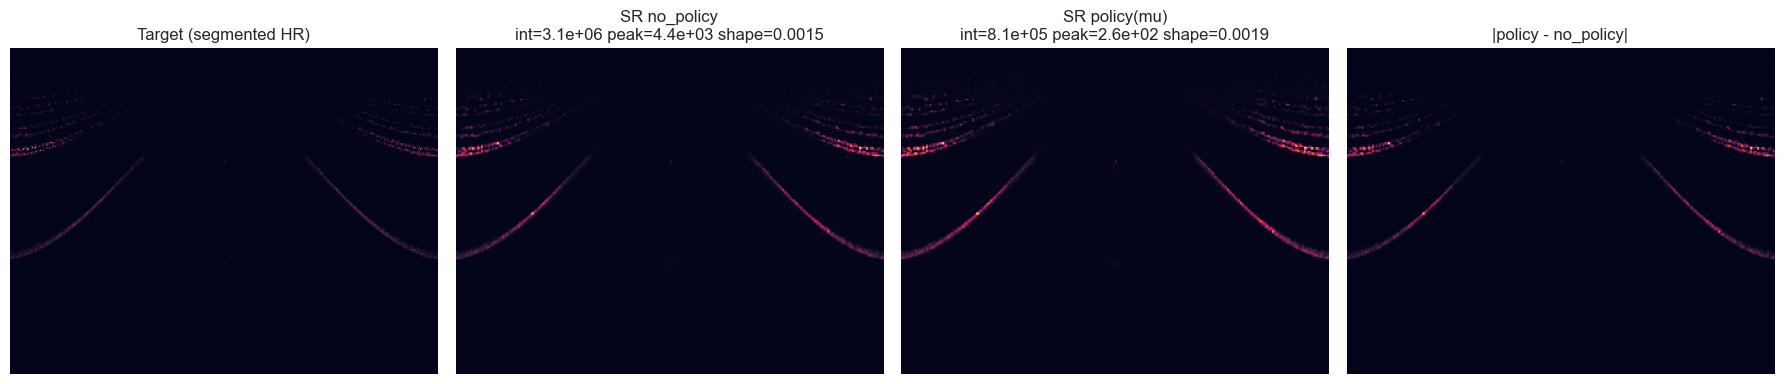

In [40]:
@torch.no_grad()
def visualize_policy_example(model, policy, loader, metrics_calculator, device, idx_in_batch=0):
    hr, _ = next(iter(loader))              # [B,1,H,W]
    hr = hr.to(device)

    # no_policy
    pred0, tgt0 = infer_no_policy(model, hr, device)          # pred0/tgt0: [B,1,H,W]

    # policy(mu)
    pred1, tgt1 = infer_with_policy_det(model, policy, hr, device)

    # берём один пример
    a = pred0[idx_in_batch, 0].detach().cpu().numpy()
    b = pred1[idx_in_batch, 0].detach().cpu().numpy()
    t = tgt1[idx_in_batch, 0].detach().cpu().numpy()  # target после сегментации (как в train)

    # метрики (abs errors)
    all0 = metrics_calculator.compute_all_metrics(pred0[idx_in_batch:idx_in_batch+1], tgt0[idx_in_batch:idx_in_batch+1], d_projection=False)
    all1 = metrics_calculator.compute_all_metrics(pred1[idx_in_batch:idx_in_batch+1], tgt1[idx_in_batch:idx_in_batch+1], d_projection=False)

    err0 = {
        "integral": float(torch.abs(all0["integral_pred"] - all0["integral_target"]).item()),
        "peak":     float(torch.abs(all0["peak_pred"]     - all0["peak_target"]).item()),
        "shape":    float(torch.abs(all0["shape_pred"]    - all0["shape_target"]).item()),
    }
    err1 = {
        "integral": float(torch.abs(all1["integral_pred"] - all1["integral_target"]).item()),
        "peak":     float(torch.abs(all1["peak_pred"]     - all1["peak_target"]).item()),
        "shape":    float(torch.abs(all1["shape_pred"]    - all1["shape_target"]).item()),
    }

    # визуализация
    fig, ax = plt.subplots(1, 4, figsize=(18, 4))

    ax[0].imshow(t, aspect="auto")
    ax[0].set_title("Target (segmented HR)")
    ax[0].axis("off")

    ax[1].imshow(a, aspect="auto")
    ax[1].set_title(f"SR no_policy\nint={err0['integral']:.2g} peak={err0['peak']:.2g} shape={err0['shape']:.2g}")
    ax[1].axis("off")

    ax[2].imshow(b, aspect="auto")
    ax[2].set_title(f"SR policy(mu)\nint={err1['integral']:.2g} peak={err1['peak']:.2g} shape={err1['shape']:.2g}")
    ax[2].axis("off")

    diff = np.abs(b - a)
    ax[3].imshow(diff, aspect="auto")
    ax[3].set_title("|policy - no_policy|")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

visualize_policy_example(model, policy, test_loader, metrics_calculator, device, idx_in_batch=0)

**Визуализации 2D + 1D**

In [43]:
class Qwrapper:
    def __init__(self, theta_range=(-170, 170), L_range=(0.1, 10), fixed_centers=None, device="cuda"):
        self.theta_range = theta_range
        self.L_range = L_range
        self.device = device

        if fixed_centers is None:
            raise ValueError("Нужно передать фиксированные центры каналов d.")

        centers = torch.tensor(fixed_centers, dtype=torch.float32)
        self.centers = centers.to(device)

        # Строим границы каналов
        edges = torch.zeros(len(centers) + 1, dtype=torch.float32)

        edges[1:-1] = (centers[:-1] + centers[1:]) * 0.5
        edges[0] = centers[0] - (centers[1] - centers[0]) * 0.5
        edges[-1] = centers[-1] + (centers[-1] - centers[-2]) * 0.5

        self.edges = edges.to(device)


    def tensor_to_d(self, batch_tensor):
        if batch_tensor.dim() != 4:
            raise ValueError("Ожидается тензор размера [B, 1, H, W]")

        B, _, H, W = batch_tensor.shape
        batch_tensor = batch_tensor.to(self.device)

        # формируем theta и L (Правильно!)
        theta_deg = torch.linspace(self.theta_range[0], self.theta_range[1], W, device=self.device)
        L_vals = torch.linspace(self.L_range[0], self.L_range[1], H, device=self.device)

        theta_rad = torch.deg2rad(theta_deg)  # [W]

        # meshgrid правильно: (H, W)
        # L зависит от строки, theta зависит от столбца
        L_grid, theta_grid = torch.meshgrid(L_vals, theta_rad, indexing="ij")
        # теперь:
        # L_grid:     [H, W]
        # theta_grid: [H, W]

        # вычисляем d
        d_grid = L_grid / (2 * torch.sin(torch.abs(theta_grid) * 0.5))

        # маска d <= 7.5
        mask = d_grid <= 7.5  # [H, W]

        results = []

        for b in range(B):
            I_mat = batch_tensor[b, 0]  # [H, W]

            # применяем маску
            d_vals = d_grid[mask]       # [N]
            I_vals = I_mat[mask]        # [N]

            # определяем индекс канала
            idx = torch.bucketize(d_vals, self.edges) - 1

            I_summed = torch.zeros(len(self.centers), device=self.device)
            I_summed.scatter_add_(0, idx.clamp(0, len(I_summed) - 1), I_vals)

            results.append({
                "d": self.centers.detach().cpu().numpy(),
                "I": I_summed.detach().cpu().numpy()
            })

        return results


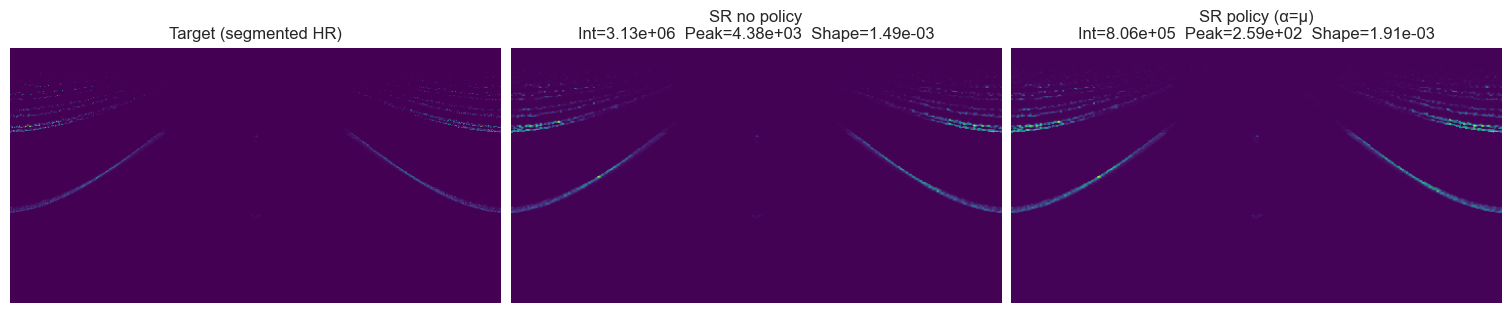

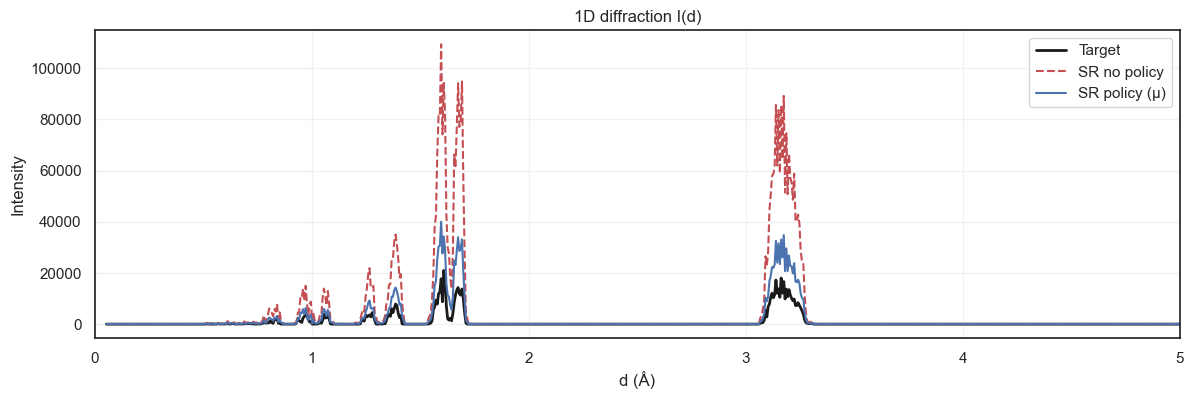

In [55]:
fixed_centers = np.linspace(0.05318052, 7.49710258, 1241)

qw = Qwrapper(
    theta_range=(-170, 170),
    L_range=(0.1, 10),
    fixed_centers=fixed_centers,
    device="cpu" 
)

@torch.no_grad()
def visualize_policy_square_2d_plus_1d(
    model,
    policy,
    loader,
    metrics_calculator,
    qwrapper,
    device,
    idx_in_batch=0,
    d_xlim=(0, 5),
    cmap="viridis",
):
    model.eval()
    policy.eval()

    hr, _ = next(iter(loader))
    hr = hr.to(device)

    # -------- inference --------
    pred0, tgt = infer_no_policy(model, hr, device)
    pred1, _   = infer_with_policy_det(model, policy, hr, device)

    tgt2d = tgt[idx_in_batch:idx_in_batch+1, 0:1]
    p0_2d = pred0[idx_in_batch:idx_in_batch+1, 0:1]
    p1_2d = pred1[idx_in_batch:idx_in_batch+1, 0:1]

    # -------- metrics --------
    m0 = metrics_calculator.compute_all_metrics(p0_2d, tgt2d, d_projection=False)
    m1 = metrics_calculator.compute_all_metrics(p1_2d, tgt2d, d_projection=False)

    def pack(m):
        return dict(
            integral=float(torch.abs(m["integral_pred"] - m["integral_target"]).item()),
            peak=float(torch.abs(m["peak_pred"] - m["peak_target"]).item()),
            shape=float(torch.abs(m["shape_pred"] - m["shape_target"]).item()),
        )

    e0, e1 = pack(m0), pack(m1)

    # -------- prepare 2D arrays --------
    img_t = tgt2d[0, 0].detach().cpu().numpy()
    img_0 = p0_2d[0, 0].detach().cpu().numpy()
    img_1 = p1_2d[0, 0].detach().cpu().numpy()

    # ================= 2D =================
    fig, ax = plt.subplots(1, 3, figsize=(15, 15), constrained_layout=True)

    ax[0].imshow(img_t, cmap=cmap, aspect="equal")
    ax[0].set_title("Target (segmented HR)")
    ax[0].axis("off")

    ax[1].imshow(img_0, cmap=cmap, aspect="equal")
    ax[1].set_title(
        "SR no policy\n"
        f"Int={e0['integral']:.2e}  Peak={e0['peak']:.2e}  Shape={e0['shape']:.2e}"
    )
    ax[1].axis("off")

    ax[2].imshow(img_1, cmap=cmap, aspect="equal")
    ax[2].set_title(
        "SR policy (α=μ)\n"
        f"Int={e1['integral']:.2e}  Peak={e1['peak']:.2e}  Shape={e1['shape']:.2e}"
    )
    ax[2].axis("off")

    plt.show()

    # ================= 1D =================
    d_tgt = qwrapper.tensor_to_d(tgt2d)[0]
    d_p0  = qwrapper.tensor_to_d(p0_2d)[0]
    d_p1  = qwrapper.tensor_to_d(p1_2d)[0]

    plt.figure(figsize=(14, 4))
    plt.plot(d_tgt["d"], d_tgt["I"], "k", lw=2, label="Target")
    plt.plot(d_p0["d"],  d_p0["I"],  "r--", lw=1.5, label="SR no policy")
    plt.plot(d_p1["d"],  d_p1["I"],  "b", lw=1.5, label="SR policy (μ)")

    plt.xlim(*d_xlim)
    plt.xlabel("d (Å)")
    plt.ylabel("Intensity")
    plt.title("1D diffraction I(d)")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()



visualize_policy_square_2d_plus_1d(
    model=model,
    policy=policy,
    loader=test_loader,
    metrics_calculator=metrics_calculator,
    qwrapper=qw,
    device=device,
    idx_in_batch=0
)
